In [2]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.expanduser("~/Developer/interpretDL/Pipeline"))

In [3]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [135]:
import numpy as np
import pandas as pd
import umap

from datetime import datetime
from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history, plot_3d_lrp
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

In [5]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(20,10),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [6]:
fname = "data/cleaned_SA.csv"
raw_data = pd.read_csv(fname, index_col=0)
raw_data.head()

,ASD_DX_group,Risk,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
103430,TYPICAL,HR,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,...,46.523426,88.635681,15.326110,268.573364,143.174347,1.515198,239.148468,20.107052,34.309757,10.180353
107524,ASD,HR,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,...,30.664413,76.203514,25.545485,188.544678,107.464104,1.381342,188.476715,17.961386,23.440365,14.530558
108372,TYPICAL,LR,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,...,35.009350,99.737000,23.199062,282.846497,29.161158,0.722310,200.596985,28.989164,32.400013,10.532928
113320,TYPICAL,LR,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,...,40.359753,111.341911,15.794782,214.678467,75.857338,1.767594,179.606552,16.667351,44.315159,12.016207
114640,TYPICAL,LR,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,...,49.686398,134.082794,18.534616,217.291306,36.213020,1.580427,181.796356,22.934441,63.739361,10.897783


In [7]:
raw_data.shape

(325, 335)

In [8]:
label_cols = ["ASD_DX_group", "Risk"]
noisy_cols = []

features = raw_data.drop(columns=noisy_cols+label_cols)
labels = raw_data[label_cols].copy()

In [9]:
labels["ASD_DX_group"][labels["Risk"]=="HR"].value_counts()

TYPICAL            149
ASD                 39
ATYPICAL_ADOS       17
ATYPICAL_MULLEN      9
Name: ASD_DX_group, dtype: int64

In [10]:
LR = labels["Risk"]=="LR"
HR = labels["Risk"]=="HR"
typical = labels["ASD_DX_group"]=="TYPICAL"
ASD = labels["ASD_DX_group"]=="ASD"

In [11]:
HR_typical = labels[HR & typical]
HR_ASD = labels[HR & ASD]

In [12]:
analysis_labels = pd.concat((HR_typical, HR_ASD))
analysis_labels["ASD_DX_group"].value_counts()

TYPICAL    149
ASD         39
Name: ASD_DX_group, dtype: int64

In [13]:
enc = OrdinalEncoder()
enc.fit(analysis_labels)
enc_labels = enc.transform(analysis_labels)
enc.categories_

[array(['ASD', 'TYPICAL'], dtype=object), array(['HR'], dtype=object)]

In [14]:
risk_labels = pd.Series(enc_labels[:,0], dtype=int, index=analysis_labels.index)
data = features.loc[analysis_labels.index].copy()

# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.3)

print(train_data.shape)
train_labels.value_counts()

(131, 333)


1    104
0     27
dtype: int64

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

ZScaler = StandardScaler().fit(train_data)
X_train = ZScaler.transform(train_data)
X_valid = ZScaler.transform(test_data)

y_train = train_labels.values.reshape(-1,1)
y_valid = test_labels.values.reshape(-1,1)

class_weight = compute_class_weight("balanced", np.unique(train_labels), train_labels)

In [16]:
def build_dnn(num_features, num_labels, activation="elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    from keras.constraints import max_norm
    keras.backend.clear_session()
    
#     tf.random.set_random_seed(RANDOM_STATE)
    reg_scale = 0.01 # For L1 Reg
#     my_reg = regularizers.l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = keras.initializers.he_normal()

    dnn.add(Dense(units = 256, activation=activation, input_dim = num_features,
                  kernel_initializer=he_init,  kernel_constraint=max_norm(4)))
    dnn.add(keras.layers.Dropout(0.2)),
    dnn.add(Dense(units = 50, activation=activation,
                  kernel_initializer=he_init,  kernel_constraint=max_norm(4)))
    dnn.add(keras.layers.Dropout(0.2))
    
    dnn.add(Dense(units=num_labels, activation="sigmoid",
                  kernel_initializer=he_init,  kernel_constraint=max_norm(4))) # 5 labels -> logits for now
    
    SGD=keras.optimizers.SGD(lr=0.001)
#     NSGD = keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=SGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [47]:
time = datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir='./logs/{}_ASDvHR_relu_10_SGD'.format(time),
                          update_freq="epoch", write_graph=False)

In [48]:
%%time
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=500, batch_size=10, verbose=0, callbacks=[tensorboard])

CPU times: user 18.6 s, sys: 4.42 s, total: 23 s
Wall time: 9.7 s


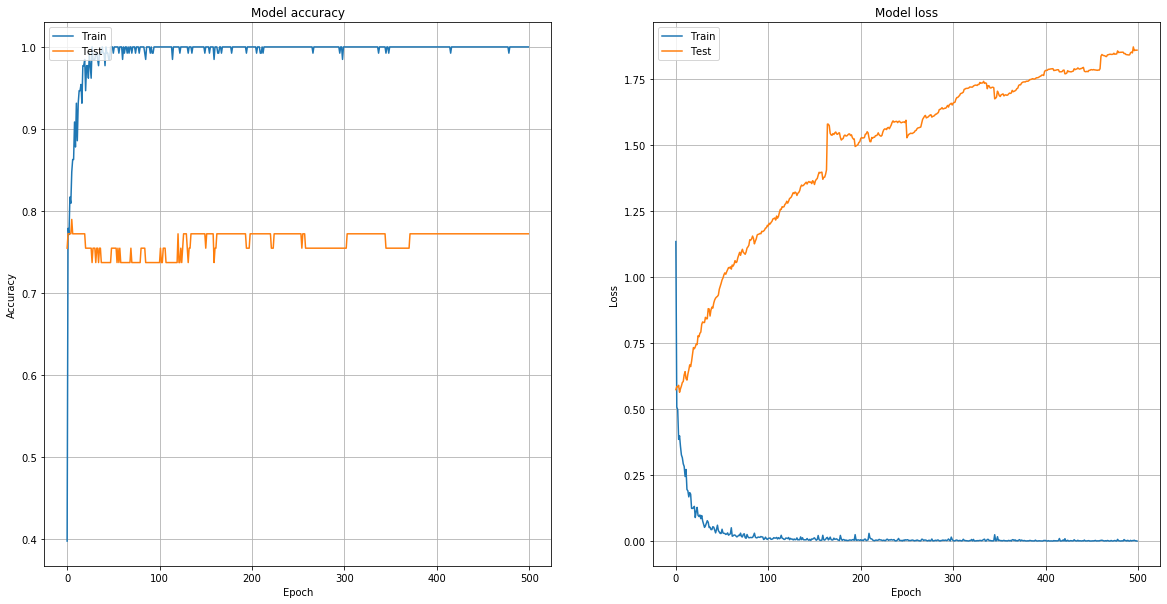

57/57 [==============================] - 0s 33us/step
Loss:1.862, Acc:0.7719


In [49]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

Confusion matrix, without normalization
[[0.         1.        ]
 [0.02222222 0.97777778]]
Overall Accuracy: 0.7719


(<matplotlib.axes._subplots.AxesSubplot at 0x1a38878a90>, array([[ 0, 12],
        [ 1, 44]]))

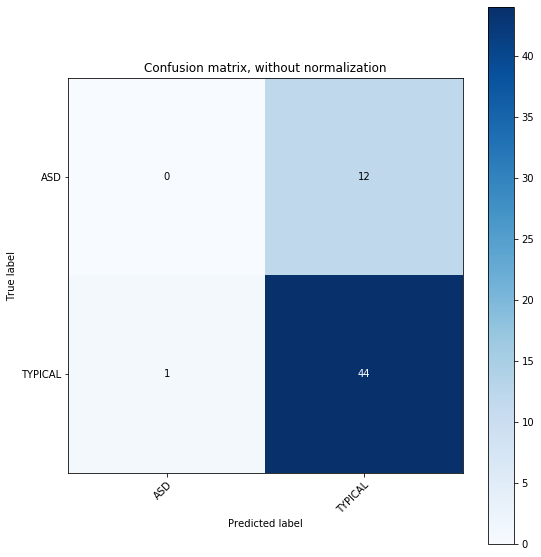

In [50]:
y_pred = np.round(np.ravel(dnn.predict(X_valid)))
plot_confusion_matrix(np.ravel(y_valid), y_pred, enc.categories_[0])

In [51]:
from sklearn.metrics import precision_score, make_scorer
prec_scorer = make_scorer(precision_score, pos_label=0)

precision_score(y_true=np.ravel(y_valid), y_pred=y_pred, pos_label=0)

0.0

## Calculate LRP

In [30]:
val_samples = analysis_labels.loc[test_labels.index]
val_samples["DNN Pred"] = y_pred
val_samples[val_samples["Risk"]=="HR"]

,ASD_DX_group,Risk,DNN Pred
CandID,,,
526558,ASD,HR,1.0
950194,ASD,HR,1.0
321541,ASD,HR,0.0
857317,ASD,HR,0.0
751794,ASD,HR,1.0
677040,ATYPICAL_MULLEN,HR,0.0
402809,ASD,HR,0.0
389521,ASD,HR,0.0
456823,ASD,HR,0.0


In [31]:
_correct = np.logical_and(y_pred == np.ravel(y_valid) , (val_samples["Risk"]=="HR").values)
_labels = val_samples[_correct]["ASD_DX_group"].values

In [32]:
correct_HR_samples = X_valid[np.logical_and(y_pred == np.ravel(y_valid) , (val_samples["Risk"]=="HR").values)]

In [41]:
import innvestigate
import innvestigate.utils as iutils

analyzer_type = "pattern.attribution"
analyzer_kwargs = {
    "pattern.attribution":
        {"pattern_type":"relu"},
    "lrp.epsilon":
        {"epsilon":1e-3}
 }

model_wo_softmax = dnn
# model_wo_softmax = iutils.keras.graph.model_wo_softmax(dnn)

analyzer = innvestigate.create_analyzer(analyzer_type, model_wo_softmax,
                                        **analyzer_kwargs[analyzer_type])
analyzer.fit(X_train, batch_size=20, verbose=1, disable_no_training_warning=True)

Epoch 1/1
7/7 [==============================] - 0s 35ms/step - loss: 3.1500 - broadcast_4_loss: 1.0000 - broadcast_5_loss: 1.0000 - broadcast_6_loss: 1.0000


In [38]:
lrp = analyzer.analyze(correct_HR_samples)
# pd.DataFrame(relevance_results)
lrp.shape

(8, 333)

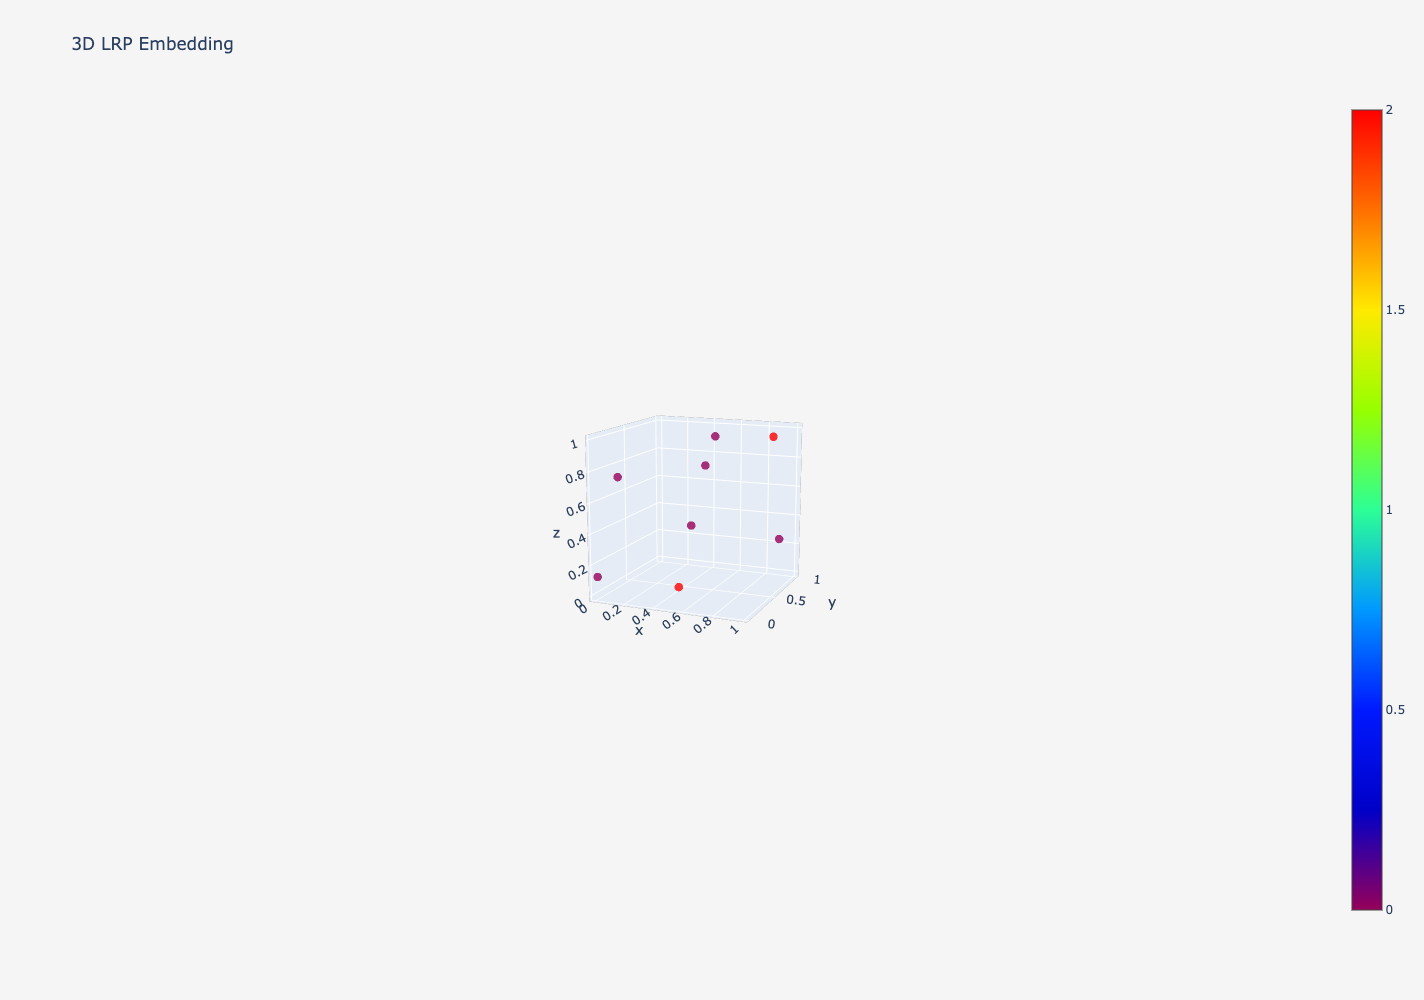

In [39]:
from sklearn.preprocessing import MinMaxScaler
from helper import plot_3d_lrp

reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=5,
                    min_dist=0)

reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
])

reducer_pipeline.fit(lrp)
embeddings = reducer_pipeline.transform(lrp)
plot_3d_lrp(embeddings, colors= enc.transform(_labels.reshape(-1,1))[:,0], labels=_labels )

### Cross Validating using Class Weights

In [101]:
# Separating a hold out set that will be used for validation of the pipeline
# train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.01)
train_data, train_labels, test_data, test_labels = data, risk_labels, [], []

In [102]:
risk_labels.value_counts()

1    149
0     39
dtype: int64

In [103]:
train_data.shape

(188, 333)

In [104]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=5,
                    min_dist=0)

In [106]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.022, Acc:1.0000
Prediction Accuracy
19/19 [==============================] - 0s 2ms/step
Scores on data set: loss=0.858 accuracy=0.8421
Fold Correct: 16
Running worker: 1
Fold: 1 -> Loss:0.033, Acc:1.0000
Prediction Accuracy
19/19 [==============================] - 0s 29us/step
Scores on data set: loss=1.128 accuracy=0.7895
Fold Correct: 15
Running worker: 2
Fold: 2 -> Loss:0.028, Acc:0.9941
Prediction Accuracy
19/19 [==============================] - 0s 47us/step
Scores on data set: loss=0.578 accuracy=0.7895
Fold Correct: 15
Running worker: 3
Fold: 3 -> Loss:0.027, Acc:0.9941
Prediction Accuracy
19/19 [==============================] - 0s 30us/step
Scores on data set: loss=1.046 accuracy=0.7368
Fold Correct: 14
Running worker: 4
Fold: 4 -> Loss:0.026, Acc:0.9941
Prediction Accuracy
19/19 [==============================] - 0s 27us/step
Scores on data set: loss=1.063 accuracy=0.7368
Fold Correct: 14
Running worker: 5
Fo

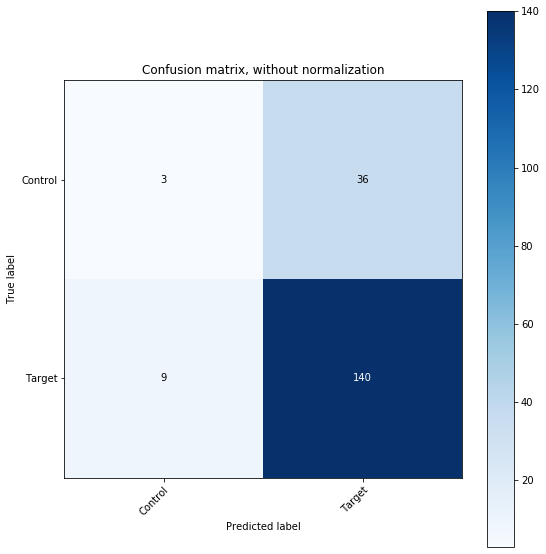

In [107]:
cm = pipeline.train_model(batch_size=int(10), epochs=500,
                          cross_validation=True, parallel=False, verbose=0)

## Crossvalidation using SMOTE internally (after folds)

In [108]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.015, Acc:0.9963
Prediction Accuracy
19/19 [==============================] - 0s 2ms/step
Scores on data set: loss=0.671 accuracy=0.7368
Fold Correct: 14
Running worker: 1
Fold: 1 -> Loss:0.012, Acc:1.0000
Prediction Accuracy
19/19 [==============================] - 0s 31us/step
Scores on data set: loss=1.109 accuracy=0.8421
Fold Correct: 16
Running worker: 2
Fold: 2 -> Loss:0.015, Acc:0.9963
Prediction Accuracy
19/19 [==============================] - 0s 33us/step
Scores on data set: loss=0.580 accuracy=0.8421
Fold Correct: 16
Running worker: 3
Fold: 3 -> Loss:0.010, Acc:1.0000
Prediction Accuracy
19/19 [==============================] - 0s 26us/step
Scores on data set: loss=0.702 accuracy=0.7895
Fold Correct: 15
Running worker: 4
Fold: 4 -> Loss:0.013, Acc:0.9963
Prediction Accuracy
19/19 [==============================] - 0s 34us/step
Scores on data set: loss=1.540 accuracy=0.6316
Fold Correct: 12
Running worker: 5
Fo

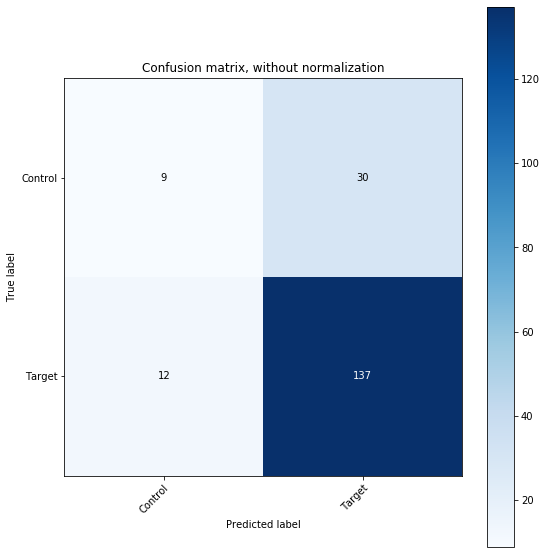

In [109]:
cm = pipeline.train_model(batch_size=int(10), epochs=500, smote=True,
                          cross_validation=True, parallel=False, verbose=0)

## SMOTE first and then classify

> ## All ASD samples are placed at the end of the array

In [110]:
print(risk_labels.value_counts())
print("===== Sanity Check =====:", all(risk_labels[risk_labels==0] == risk_labels[-(len(HR_ASD)):]))

1    149
0     39
dtype: int64
===== Sanity Check =====: True


In [111]:
from imblearn.over_sampling import SMOTE

synth_train, synth_y = SMOTE(random_state=RANDOM_STATE, k_neighbors=3).fit_resample(data,risk_labels) # Both are np arrays now

In [112]:
print("Oversampling Maintained Order:",
    np.array_equiv(
        data[len(HR_typical):].values,
       synth_train[len(HR_typical):len(HR_typical)+len(HR_ASD)]
))

Oversampling Maintained Order: True


In [113]:
num_synths=len(synth_train)-len(data)
num_synths

110

In [121]:
synth_samples = pd.DataFrame(synth_train[-num_synths:],
                             index=range(-1,-num_synths-1,-1),
                             columns=data.columns)
synth_labels = pd.Series(synth_y[-num_synths:],
                             index=range(-1,-num_synths-1,-1))
synth_samples.head()

,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,ROI09,ROI10,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
-1,681.959544,279.420115,179.296476,131.060501,424.424836,619.104182,46.671059,180.392090,28.100171,62.323375,...,80.641994,121.229494,21.736134,219.648968,46.300525,1.479926,250.823066,27.960548,32.745146,14.771461
-2,779.296469,279.143081,150.156493,150.339773,427.407365,544.704695,29.617299,150.984774,54.881513,56.755046,...,45.792315,99.277028,20.324129,192.068940,41.701157,0.905107,217.231994,20.103305,34.812005,17.441114
-3,819.465480,261.052197,149.893565,159.224046,399.038619,594.604442,24.189074,146.131577,57.393515,57.478831,...,46.745756,104.109025,20.282331,190.894814,39.546991,0.781301,233.125553,20.017632,32.474915,16.253035
-4,555.941037,288.541801,161.178271,146.866719,431.936390,504.977575,65.814938,178.050238,35.086963,50.797106,...,49.689160,101.441515,17.622310,159.814628,40.120537,1.202629,197.325392,25.668171,47.066586,14.810970
-5,593.079761,331.134046,153.296000,139.736926,479.333263,439.933027,47.448872,170.101318,45.624587,49.499738,...,45.442018,102.249051,19.392015,225.684785,51.648367,1.258223,172.676318,22.271923,43.125403,14.024455


In [157]:
synth_data = pd.concat([data, synth_samples],axis=0)
combined_labels = pd.concat([risk_labels, synth_labels],axis=0)

synth_train_data, synth_train_labels, test_data, test_labels = synth_data, combined_labels, [], []

In [158]:
dnn = build_dnn(num_features=synth_data.shape[1], num_labels=1, activation="relu")
smote_pipeline = ClusterPipeline(dnn, [synth_train_data, synth_train_labels],[test_data, test_labels],
                                 target_class=0, reducer=reducer, softmax=False,
                                 analyzer_type="pattern.attribution")

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.011, Acc:1.0000
Prediction Accuracy
30/30 [==============================] - 0s 1ms/step
Scores on data set: loss=0.253 accuracy=0.9000
Fold Correct: 27
Epoch 1/1
14/14 [==============================] - 0s 14ms/step - loss: 3.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000 - broadcast_3_loss: 1.0000
Running worker: 1
Fold: 1 -> Loss:0.015, Acc:1.0000
Prediction Accuracy
30/30 [==============================] - 0s 23us/step
Scores on data set: loss=0.149 accuracy=0.9333
Fold Correct: 28
Epoch 1/1
14/14 [==============================] - 1s 36ms/step - loss: 3.0000 - broadcast_4_loss: 1.0000 - broadcast_5_loss: 1.0000 - broadcast_6_loss: 1.0000
Running worker: 2
Fold: 2 -> Loss:0.013, Acc:1.0000
Prediction Accuracy
30/30 [==============================] - 0s 25us/step
Scores on data set: loss=0.598 accuracy=0.8667
Fold Correct: 26
Epoch 1/1
14/14 [==============================] - 0s 22ms/step - loss: 3.0000 -

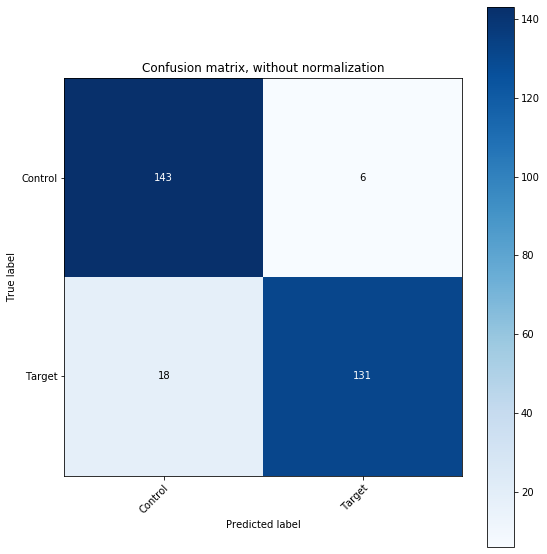

In [159]:
cm = smote_pipeline.train_model(batch_size=int(10), epochs=500, cross_validation=True,
                                parallel=False, verbose=0)

In [187]:
reindexed_labels = synth_train_labels.iloc[smote_pipeline.testing_idxs]
preds = pd.DataFrame(smote_pipeline.predictions, index = reindexed_labels.index, dtype=int)
correct_idxs = smote_pipeline.correct_preds_bool_arr
# preds = reindexed_labels[correct_idxs]

# All negative indices correspond to synthetic samples
real_sample_preds = preds[preds.index > 0]

Confusion matrix, without normalization
[[0.84615385 0.15384615]
 [0.12080537 0.87919463]]
Overall Accuracy: 0.8723


(<matplotlib.axes._subplots.AxesSubplot at 0x1a47c0f240>, array([[ 33,   6],
        [ 18, 131]]))

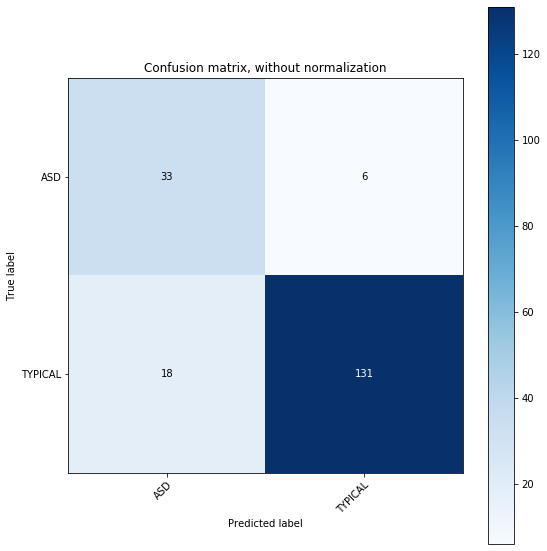

In [163]:
y_pred = real_sample_preds
y_true = risk_labels.loc[real_sample_preds.index]
plot_confusion_matrix(y_true, y_pred, enc.categories_[0])

## Plotting LRP on pre-SMOTE N/W

In [225]:
correct_preds = preds[correct_idxs]
ASD_preds = correct_preds[correct_preds.values == 0]
real_ASD_preds = ASD_preds.index > 0
# real_ASD_preds

In [211]:
from sklearn.preprocessing import MinMaxScaler
reducer = umap.UMAP(random_state=42,
                    n_components = 100,
                    n_neighbors=15,
                    min_dist=0)

smote_pipeline.reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
        ])

_, correct_pred_idxs = smote_pipeline.train_clusterer(plot=False, class_label=0)
print("Clusters Found:", max(smote_pipeline.clusterer.labels_)+1)

LRP Shape:  (143, 333)
Cluster Search Space: range(12, 18)
Minimum Size:
Clusters                  (14, 14)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object
Clusters Found: 3


In [216]:
plot_3d_lrp(smote_pipeline.training_lrp[real_ASD_preds], colors=smote_pipeline.clusterer.labels_[real_ASD_preds])

In [194]:
_pipeline_lrp = smote_pipeline.training_lrp.copy()

In [210]:
smote_pipeline.training_lrp = _pipeline_lrp.copy()

In [208]:
_pipeline_lrp.shape

(143, 333)

In [194]:
smote_pipeline.training_lrp[real_ASD_preds].shape

(33, 333)

In [222]:
from sklearn.preprocessing import MinMaxScaler
import hdbscan

reducer = umap.UMAP(random_state=42,
                    n_components = 25,
                    n_neighbors=7,
                    min_dist=0)

smote_pipeline.reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
        ])

ASD_lrp = smote_pipeline.training_lrp[real_ASD_preds]

print("LRP Shape: ", ASD_lrp.shape)
reducer_pipeline = smote_pipeline.reducer_pipeline.fit(ASD_lrp)
embeddings = smote_pipeline.reducer_pipeline.transform(ASD_lrp)
min_cluster_sizes=[]
if not min_cluster_sizes:
    n_neighbours = reducer_pipeline["umap"].n_neighbors
    min_cluster_sizes = range(n_neighbours-3, n_neighbours+3)

print("Cluster Search Space:", min_cluster_sizes)
scores = smote_pipeline.clusterPerf(embeddings, labels, min_cluster_sizes, plot=False)
print("Minimum Size:")
print(scores.idxmin())

minsize, minsamp = scores["Halkidi-Filtered Noise"].idxmin()
ASD_clusterer = hdbscan.HDBSCAN(min_cluster_size=minsize,
                                 min_samples=minsamp, prediction_data=True)
ASD_clusterer.fit(embeddings)
print("Clusters Found:", max(ASD_clusterer.labels_)+1)

LRP Shape:  (33, 333)
Cluster Search Space: range(4, 10)
Minimum Size:
Clusters                  (6, 6)
Noise                     (4, 4)
Halkidi                   (4, 4)
Halkidi-Filtered Noise    (4, 4)
dtype: object
Clusters Found: 3


In [223]:
plot_3d_lrp(ASD_lrp, colors=ASD_clusterer.labels_)